# Pushing particles using UXArray with FESOM2 data

In this notebook, we look at advecting particles with a static velocity field provided by a FESOM2 dataset ("channel_lizarbe"). The purpose of this notebook is to explore what the signatures of horizontal and vertical interpolation would look like so that we can best plan how to implement in Parcels v4. The top half of the notebook aims to define the interpolation methods and verify that they are working as expected. The bottom half aims to integrate these methods with some of the existing Parcels infrastructure. The intention of this exercise is to develop some understanding of how we can work towards providing unstructured grid support in Parcels.

## Integration with Parcels
In this demo, we do our best to closely mirror the simple tutorial at https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html . The main difference here is that we aim to avoid using Parcel's in-built `FieldSet` and `GridSet` classes for defining the state of the ocean. Instead, we opt to use the `UXArray.dataset` and `UXArray.grid` for the ocean state and grid description. To make this possible, we need to adjust the following functions in Parcels 

* `particleSet.from_list` - this needs to be adjusted to be able to use a `UXArray.dataset` in place of the `fieldSet`. In this example, we do this as a type extension of the `particleSet` class.
* Advection kernels will need to be overriden to use a method similar to `FieldSet.UV` (https://github.com/ELPHE-WW/Parcels/blob/master/parcels/application_kernels/advection.py) to obtain the ocean state velocity components at particle positions. For simplicity, we will write a kernel for first order Euler method, which simply obtains the velocity at the particle positions. *I think, that we should be able to simply define this kernel and use this kernel in the kernel definition for the `particleset`*

To add a `UV` attribute to the `UXArray.dataset`, we can do something similar to `fieldset._add_UVfield` (https://github.com/ELPHE-WW/Parcels/blob/master/parcels/fieldset.py#L231)

## Working outside of Parcels
For this first part of the notebook, we don't even consider Parcels. We just focus on adapting the search and interpolation methods discussed in the [Particle-pushing.ipynb](./Particle-pushing.ipynb) notebook to use the attributes from the UXArray dataset.

First, we create our UXArray grid and dataset using the `channel_lizarbe` demo. This provides an unstructured grid with the three components of a static velocity field.

In [1]:
import uxarray as ux

grid_path="./data/channel_lizarbe/fesom.mesh.diag.nc"
data_path=["./data/channel_lizarbe/u.fesom.2005_cut.nc",
           "./data/channel_lizarbe/v.fesom.2005_cut.nc",
           "./data/channel_lizarbe/w.fesom.2005_cut.nc"]

uxds = ux.open_mfdataset(grid_path,data_path)
uxds

<xarray.UxDataset> Size: 8MB
Dimensions:  (nz1: 40, time: 1, n_face: 21120, nz: 41, n_node: 10608)
Coordinates:
  * nz1      (nz1) float64 320B 4.519 14.01 24.45 ... 3.459e+03 3.814e+03
  * time     (time) datetime64[ns] 8B 2005-01-01T23:50:00
  * nz       (nz) float64 328B 0.0 9.038 18.98 ... 3.29e+03 3.628e+03 4e+03
Dimensions without coordinates: n_face, n_node
Data variables:
    u        (time, nz1, n_face) float32 3MB dask.array<chunksize=(1, 40, 21120), meta=np.ndarray>
    v        (time, nz1, n_face) float32 3MB dask.array<chunksize=(1, 40, 21120), meta=np.ndarray>
    w        (time, nz, n_node) float32 2MB dask.array<chunksize=(1, 41, 10608), meta=np.ndarray>

## Spatial Hashing with UXArray Data
Recall from the [Particle Pushing notebook](./Particle-pushing.ipynb) that we want to implement spatial hashing for the element search. Spatial hashing is preferred because the algorithm complexity is O(1), meaning it will scale to larger meshes very well. This is owed to the fact that we relate the particle positions and the unstructured grid face positions to the hash cells. Computing the hash cell indices is equivalent to two integer divisions. For a particle, we compute hash cell indices (`i` and `j`) and then use this to find a short, fixed sized list of elements that are also related to the hash cell.

First, we need to be able to generate the structured hash grid from the UXArray grid information. Following our work in the [Particle Pushing notebook](./Particle-pushing.ipynb), the hash cell size is calculated using a length that is proportional to the median edge length of all the edges in the unstructured grid. 

Here, the `calculate_hash_cell_size` function takes in the uxarray grid and a scale factor and returns the hash cell size. The hash cell size is the scale factor multiplied by the median element bounding box diagonal.

In [8]:
import uxarray 
from typing import Union
import numpy as np


def calculate_hash_cell_size(uxobj: Union[uxarray.UxDataset, uxarray.Grid], scalefac: float = 1.0):
    """
    Calculate the hash cell size using the median edge length as a characteristic length scale. The characteristic
    length scale is optionally scaled by the provided `scalefac` parameter to obtain the hash cell grid size.
    At the moment, the hash cell size is returned in units of degrees.
    
    Parameters:
    - uxobj (uxarray.UXDataSet or uxarray.Grid type) : uxarray object containing the grid either as a Grid or UXDataSet
    - scalefac (float): Multiplier for the median triangle diagonal length to set the hash cell size
    
    Returns:
    - cell_size (float): The recommended hash cell size.
    """
    import numpy as np

    if isinstance(uxobj, uxarray.UxDataset):
        grid = uxobj.uxgrid
    elif isinstance(uxobj, uxarray.Grid):
        grid = uxobj
    else:
        raise TypeError(f"Unsupported type: {type(uxobj)}")

    # The uxarray grid.edge_node_distances method returns
    # the distances in units of degrees
    return grid.edge_node_distances.median().to_numpy()*180.0/np.pi*scalefac # Need to return the hash size in degrees


# Calculate hash cell size
hash_cell_size = calculate_hash_cell_size(uxds,0.5)
print( f"Hash cell size : {hash_cell_size}")

# Get the bounding box for the domain
x_max = uxds.uxgrid.node_lon.max().to_numpy()
x_min = uxds.uxgrid.node_lon.min().to_numpy()
y_max = uxds.uxgrid.node_lat.max().to_numpy()
y_min = uxds.uxgrid.node_lat.min().to_numpy()

# To determine how many hash cells we need, we divide the domain length by the hash_cell_size
Lx = (x_max-x_min)
Ly = (y_max-y_min)
print( f"Domain size (Lx,Ly) : ({Lx},{Ly})")
nxh = int(np.ceil(Lx/hash_cell_size))
nyh = int(np.ceil(Ly/hash_cell_size))
print( f"Number of hash cells (nxh,nyh) : ({nxh},{nyh})")



Hash cell size : 0.0467416231183601
Domain size (Lx,Ly) : (4.4531,17.9049)
Number of hash cells (nxh,nyh) : (96,384)


### Handling periodic boundary conditions

In some examples, like the one we are focusing on here, the longitude direction may be periodic, even if the longitudinal range does not span `[0,360]` degrees. In this case, we need to be careful. 

The figure in the code block below shows the southern portion of the example mesh we are looking at. Nodes on the western side of the domain show long edges that extend to nodes on the east most boundary. These edges are assigned in FESOM to handle periodic boundary conditions numerically. However, we will be using a geometric check, based on the corner nodes of each face to determine if a particle is inside or outside a 2-D face.

In [3]:
def periodic_image(x, x_min, x_max):
    """
    Wraps a value to its periodic extension (To the left) for the domain [x_min,x_max] .The left periodic extension of this domain is [x_min-Lx,x_max-Lx]
    """
    dxr = x_max - x # distance from right boundary
    x_wrapped = x_min - dxr # shift from min
    return x_wrapped

periodic_image(4.4531, 0.0, 4.5)

-0.04689999999999994

In [47]:
( 
    uxds.uxgrid.plot.edges(color="Blue",line_width=2) 
    * uxds.uxgrid.plot.nodes(color="Red",size=7)
).opts( 
        title="FESOM2 Mesh",
        xlim = (-0.1,4.5),
        ylim = (0,1)
    )


:Overlay
   .Path.I   :Path   [Longitude,Latitude]
   .Points.I :Points   [lon,lat]

In [4]:
print(f"Min lon : {uxds.uxgrid.node_lon.min().to_numpy()}")
print(f"Max lon : {uxds.uxgrid.node_lon.max().to_numpy()}")

Min lon : 0.0
Max lon : 4.4531


#### Relating the the unstructured mesh elements to the hash cells
Now that we have the hash cell size, we now want to create a lookup table where we can put in the hash cell indices `(i,j)` and retrieve a list of elements whose bounding boxes overlap the hash cells. This way, when we want to map the particle positions to the triangular element id's we can first do a fast lookup against the hash cells. Once we have the hash cell id for the particle position, we can get a short list of triangles that we can use to check if the particle resides in.



Minimum triangle count per hash cell : 2.0
Maximum triangle count per hash cell : 8.0
Median triangle count per hash cell  : 6.0
Number of non-empty hash cells       : 36864 ( 100.0 %)


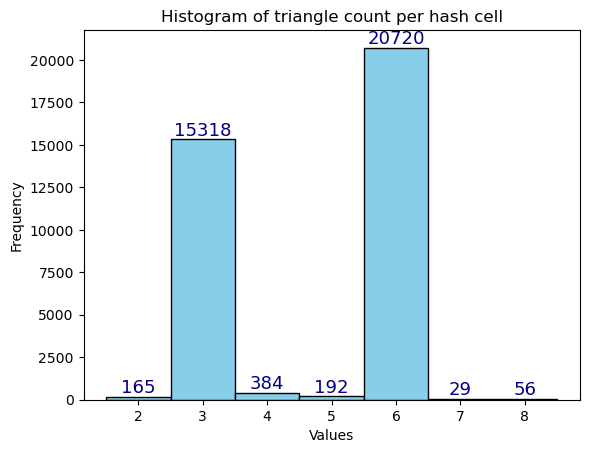

In [ ]:
import numpy as np

def get_triangles_in_hash_cells(uxobj: Union[uxarray.UxDataset, uxarray.Grid], xwest, xeast, nxh, nyh, cell_size):
    """
    Efficiently find the list of triangles whose bounding box overlaps with the specified hash cells.
    
    Parameters:
    - uxobj (uxarray.UXDataSet or uxarray.Grid type) : uxarray object containing the grid either as a Grid or UXDataSet
    - xwest (float) : longitude of the western extent of the model domain
    - xeast (float) : longitude of the eastern extent of the model domain
    - nxh (int) : The number of hash cell vertices in the x-direction
    - nyh (int) : The number of hash cell vertices in the y-direction
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    
    Returns:
    - overlapping_triangles (dict): A dictionary where keys are the hash cell index and values are lists of triangle indices.
    """
    import numpy as np
    if isinstance(uxobj, uxarray.UxDataset):
        grid = uxobj.uxgrid
    elif isinstance(uxobj, uxarray.Grid):
        grid = uxobj
    else:
        raise TypeError(f"Unsupported type: {type(uxobj)}")
    
    overlapping_triangles = [[] for i in range(nxh*nyh)]

    lon_bounds = grid.face_bounds_lon.to_numpy()
    lon_bounds_periodic_image = periodic_image(lon_bounds,xwest,xeast)
    lat_bounds = grid.face_bounds_lat.to_numpy()

    # Loop over each triangle element
    for eid in range(grid.n_face):
        
        # Calculate the bounding box of the triangle
        x_min = lon_bounds[eid,0]
        x_max = lon_bounds[eid,1]
        dx = x_max - x_min

        # Here, we need to make adjustments for potentially periodic boundaries.
        # We can look at calculating the bounding box using the reported value for x_max
        # from `grid.face_bounds_lon` or using its periodic image.
        x_max_periodic_image = lon_bounds_periodic_image[eid,1]
        dx_p = x_min - x_max_periodic_image

        # If the difference between x_min and the the periodic image of x_max is 
        # less than the difference between x_min and x_max, then we set x_max = x_min
        # and x_min = x_max_periodic_image
        if( dx_p < dx ):
            x_max = x_min
            x_min = x_max_periodic_image
        

        y_min = lat_bounds[eid,0]
        y_max = lat_bounds[eid,1]

        # Find the hash cell range that overlaps with the triangle's bounding box
        i_min = int(np.floor(x_min / cell_size))
        i_max = int(np.floor(x_max / cell_size))
        j_min = int(np.floor(y_min / cell_size))
        j_max = int(np.floor(y_max / cell_size))
        
        # Iterate over all hash cells that intersect the bounding box
        for j in range(j_min, j_max + 1):
            for i in range(i_min, i_max + 1):
                overlapping_triangles[i+nxh*j].append(eid)
                    
    return overlapping_triangles

import matplotlib.pyplot as plt

x_min = 0.0 # Western extent of the domain
x_max = 4.5 # Eastern extent of the domain

hashmap = get_triangles_in_hash_cells(uxds,x_min,x_max,nxh,nyh,hash_cell_size)

## Count how many triangles are in each hash cell.
hashmap_triangle_count = np.zeros(len(hashmap))
k=0
for t in hashmap:
    hashmap_triangle_count[k]=len(t)
    k+=1

nnonzero = np.count_nonzero(hashmap_triangle_count)
print(f"Minimum triangle count per hash cell : {np.min(hashmap_triangle_count)}")
print(f"Maximum triangle count per hash cell : {np.max(hashmap_triangle_count)}")
print(f"Median triangle count per hash cell  : {np.median(hashmap_triangle_count)}")
print(f"Number of non-empty hash cells       : {nnonzero} ( {nnonzero/len(hashmap)*100.0} %)")

# Plotting a basic histogram
bin_edges = np.arange( np.min(hashmap_triangle_count)-0.5, np.max(hashmap_triangle_count)+1.5,1)
values, bins, bars = plt.hist(hashmap_triangle_count, bins=bin_edges, color='skyblue', edgecolor='black',align='mid')
plt.bar_label(bars, fontsize=13, color='navy')
# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of triangle count per hash cell')
 
# Display the plot
plt.show()

The hash cells are defined by their lower left corner and their size. Here, we are assuming the hash cells are squares. To create the hash cells, we first define the bounding box of the domain spanned by the unstructured mesh. From this and the hash cell size, we can determine the number of hash cells in the mesh. Since the hash cells are non-overlapping elements in a structured grid, we can easily generate a unique integer for each hash cell `idx = i + nxh*j` where `i` is the index in the `x` direction and `j` is the index in the `y` direction. This allows us to create a hash table that takes a unique integer `idx` and returns the list of elements that overlap the hash cell.

To make calculation of the `i` and `j` indices simple, the hash cell grid is assumed to have an origin at `(0,0)`. Consquently, the unstructured grid is shifted so that its origin is also at `(0,0)`.

When using spatial hashing to determine which unstructured element a particle resides in, we have to first map the particle to the hash cell. This is inexpensive since calculating `idx` is reduced to calculating `i = floor(xp / cell_size)` and `j = floor(xp / cell_size)`. Once we have the hash cell that the particle resides in, we then look through the list of elements associated with that hash cell and perform checks to determine which element the particle is in. This is typically done by calculating the barycentric coordinates for the particle and checking if this places the particle inside or outside the element. This is more computationally expensive than the hash cell lookup.

With this in mind, we want to get a feel for the number of triangular elements associated with each hash cell. After creating the hash table, the end of the code snippet below looks into the distribution of triangles per hash cell.

#### Aligning the particles with a hash cell
Now that we have the hash map defined and we have associated a list of triangle elements with each hash cell, we can now start working on the search method to map a particle position to an element. The first step in this process is to map the particle position to the hash cell.

As mentioned previously, calculating the hash cell that each particle resides in is fairly straightforward. Given a list of `x` and `y` positions for particles, we can calculate `i = int(floor( x / cell_size ))` and `j = int(floor( y / cell_size ))`. To calculate the unique integer for the hash table lookup, we simply set the hash table id to `idx = i + nxh*j` for each particle. 


In [10]:
def get_particles_in_hash_cells(nxh, nyh, xp, yp, cell_size):
    """
    Efficiently map the particle positions to the hash
    
    Parameters:
    - nxh (int) : The number of hash cell vertices in the x-direction
    - nyh (int) : The number of hash cell vertices in the y-direction
    - xp (np.ndarray): Array of x component of the particle positions (length = np)
    - yp (np.ndarray): Array of y component of the particle positions (length = np)
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    
    Returns:
    - particle_hash (np.ndarray(dtype=int)): Array of size (np) that stores the hash cell index for the particles
    """
    import numpy as np
    
    particle_hash = np.zeros(xp.size,dtype=int)

    for k in range(xp.size):
        i = int(np.floor(xp[k] / cell_size))
        j = int(np.floor(yp[k] / cell_size))
        particle_hash[k] = i+nxh*j
        
    return particle_hash


Now that we have the function for associating a hash table index with each particle, let's generate some particles and try it out. Here, we generate arrays for x and y positions of particles using a random uniform distribution of values between `[x_min,x_max]` and `[y_min,y_max]`. These positions are then passed into the `get_particles_in_hash_cells` function which returns an array that is of length `num_particles` and contains the hash cell id associated with each particle.

In [12]:
num_particles = 100
xp = np.zeros(num_particles)
yp = np.zeros(num_particles)
for k in range(num_particles):
    xp[k] = np.random.uniform(x_min, x_max)
    yp[k] = np.random.uniform(y_min, y_max)


particle_hash_ids =  get_particles_in_hash_cells(nxh, nyh, xp, yp, hash_cell_size)

# From the unique id, we can back out the i and j indices using modulo arithmetic
p_i = particle_hash_ids % nxh
p_j = (particle_hash_ids/nxh).astype(int)
for k in range(num_particles):
    print(f"Particle {k} hash id : {particle_hash_ids[k]} = ({p_i[k]},{p_j[k]})")

Particle 0 hash id : 13461 = (21,140)
Particle 1 hash id : 13495 = (55,140)
Particle 2 hash id : 9991 = (7,104)
Particle 3 hash id : 21438 = (30,223)
Particle 4 hash id : 28403 = (83,295)
Particle 5 hash id : 11044 = (4,115)
Particle 6 hash id : 24673 = (1,257)
Particle 7 hash id : 5189 = (5,54)
Particle 8 hash id : 24551 = (71,255)
Particle 9 hash id : 20127 = (63,209)
Particle 10 hash id : 23026 = (82,239)
Particle 11 hash id : 27474 = (18,286)
Particle 12 hash id : 32562 = (18,339)
Particle 13 hash id : 15848 = (8,165)
Particle 14 hash id : 3597 = (45,37)
Particle 15 hash id : 29236 = (52,304)
Particle 16 hash id : 6004 = (52,62)
Particle 17 hash id : 24516 = (36,255)
Particle 18 hash id : 16385 = (65,170)
Particle 19 hash id : 27353 = (89,284)
Particle 20 hash id : 7545 = (57,78)
Particle 21 hash id : 31639 = (55,329)
Particle 22 hash id : 24302 = (14,253)
Particle 23 hash id : 13697 = (65,142)
Particle 24 hash id : 4913 = (17,51)
Particle 25 hash id : 28698 = (90,298)
Particle 26 

With each particle now having a list of possible elements they could reside in, we now need to develop a check for determining if a particle is inside or outside a triangle. Determining whether a particle is inside or outside a triangle can be done using **barycentric coordinates**. 

Barycentric coordinates provide a convenient way to express any point inside a triangle in terms of the triangle's vertices. The idea is to express a point $( P )$ as a combination of the vertices of the triangle $( A )$, $( B )$, and $( C )$.

Let the vertices of the triangle be:
- $( A = (x_A, y_A) )$
- $( B = (x_B, y_B) )$
- $( C = (x_C, y_C) )$

Given a point $( P = (x_P, y_P) )$, we can determine if it lies inside the triangle by solving for the barycentric coordinates $( \lambda_1, \lambda_2, \lambda_3 )$, such that:

$P = \lambda_1 A + \lambda_2 B + \lambda_3 C$

Geometrically, the value of each coordinate represents the proportional area of the sub-triangle formed by the point P and the opposite edge of the original triangle. If a point lies inside the triangle, all of its barycentric coordinates are between 0 and 1. Mathematically, we can write

$\lambda_1 = Area(BCP)/Area(ABC)$
$\lambda_1 = Area(CAP)/Area(ABC)$
$\lambda_3 = Area(ABP)/Area(ABC)$

The area of a triangle given only three points can be calculated as

$ A = 1/2 ( x_1(y_2-y_3) + x_2(y_3-y_1) + x_3(y_1-y_2))$

All of this is put together in the `barycentric_coordinates` function below, which takes a particle position and a triangular element's vertices and computes the barycentric coordinates. Additionally, it reports if the particle is inside or outside the triangle. 

Here, we'll just look at the first particle and the first element it is associated with to test this out. To get the particle position, we simply take `xp[0]` and `yp[0]`. To get the triangle vertices, we use the particle's hash cell id to obtain the list of triangular elements it may be associated with. We take the first element id from this list and use this to obtain the corresponding vertex ids. From the vertex ids, we obtain the `x` and `y` positions from the `vertices` array.

In [ ]:
def barycentric_coordinates(xP, yP, triangle_vertices):
    """
    Compute the barycentric coordinates of a particle in a triangular element
    
    Parameters:
    - xP, yP: The coordinates of the particle
    - triangle_vertices (np.ndarray) : The vertices of the triangle as a (3,2) array.
    
    Returns:
    - The barycentric coordinates (l1,l2,l3)
    - True if the point is inside the triangle, False otherwise.
    """
    
    xv = np.squeeze(triangle_vertices[:,0])
    yv = np.squeeze(triangle_vertices[:,1])

    A_ABC = xv[0]*(yv[1]-yv[2]) + xv[1]*(yv[2]-yv[0]) + xv[2]*(yv[0]-yv[1])
    A_BCP = xv[1]*(yv[2]-yP   ) + xv[2]*(yP   -yv[1]) + xP   *(yv[1]-yv[2])
    A_CAP = xv[2]*(yv[0]-yP   ) + xv[0]*(yP   -yv[2]) + xP   *(yv[2]-yv[0])
    A_ABP = xv[0]*(yv[1]-yP   ) + xv[1]*(yP   -yv[0]) + xP   *(yv[0]-yv[1])

    # Compute the vectors
    l1 = A_BCP/A_ABC
    l2 = A_CAP/A_ABC
    l3 = A_ABP/A_ABC
    
    inside_triangle = all( [l1 >= 0.0, l1 <= 1.0, 
                            l2 >= 0.0, l2 <= 1.0,
                            l3 >= 0.0, l3 <= 1.0] )
    
    return l1,l2,l3,inside_triangle


# Example usage using the first particle
pid = 0
# Get the particle position
xP = xp[pid]
yP = yp[pid]

# Get the hash cell id for the particle
idx = particle_hash_ids[pid]

# Get the first possible element we want to check
eid = triangles_hashmap[idx][0]

# From the element, get the vertices
vertex_ids = elements[eid]
triangle_vertices = vertices[vertex_ids]

print(f"Particle position  : ({xP},{yP})")
print(f"Hash cell id       : {idx}")
print(f"Element id         : {eid}")
print(f"Vertex ids         : {vertex_ids}")
print(f"Triangle vertices  : {triangle_vertices[0],triangle_vertices[1],triangle_vertices[2],}")

# Get the barycentric coordinates
l1,l2,l3,is_inside = barycentric_coordinates(xP,yP,triangle_vertices)

print(f"Barycentric coords : ({l1},{l2},{l3})")
print(f"Is inside          : {is_inside}")


Particle position  : (1.3182667440290392,0.38852212923279406)
Hash cell id       : 12
Element id         : 2
Vertex ids         : [1 2 5]
Triangle vertices  : (array([1, 0]), array([2, 0]), array([1, 1]))
Barycentric coords : (0.29321112673816674,0.3182667440290392,0.38852212923279406)
Is inside          : True
